# 1. Building basic QNN example
## 1.a Construct a 2-qubit basic quantum  neural network
> 2011.00027 논문을 참고하거나, 자유롭게 FeatureMap과 Ansatz 사용

In [237]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

def FeatureMapBuilder(num_features, reps):
    feature_map = ZZFeatureMap(
        feature_dimension=num_features,
        reps=reps,
    )
    return feature_map

def AnsatzBuilder(num_qubits, reps):
    ansatz = TwoLocal(
        num_qubits=num_qubits,
        rotation_blocks='ry',
        entanglement_blocks='cx',
        entanglement='full', 
        reps=reps, 
        insert_barriers=True
    )
    return ansatz

from qiskit_machine_learning.circuit.library import QNNCircuit

def QnnModelCircuitBuilder(num_qubits, reps_feature_map, reps_ansatz):
    feature_map = FeatureMapBuilder(num_qubits, reps_feature_map)
    ansatz = AnsatzBuilder(num_qubits, reps_ansatz)

    qnn_circuit = QNNCircuit(
        num_qubits=num_qubits,
        feature_map=feature_map,
        ansatz=ansatz
    )
    return qnn_circuit

- ZZFeatureMap 기반 FeatureMap 생성 함수
- TwoLocal 회로 기반 Ansatz 생성 함수
- QNN circuit 생성 함수


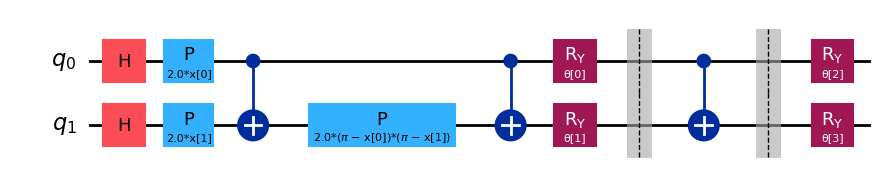

In [238]:
qnn_circuit = QnnModelCircuitBuilder(
    num_qubits=2,
    reps_feature_map=1,
    reps_ansatz=1
)

qnn_circuit.decompose().draw("mpl")

## 1.b. Compute Effective Dimension of the Model
> Training data의 Distribution에 대한 dependence를 찾기
- by varying the input data

In [239]:
from qiskit.primitives import StatevectorSampler as Sampler
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN

In [240]:
sampler = Sampler()
#Sampler 기반 QNN인 samplerQNN 정의
qnn = SamplerQNN(
    circuit=qnn_circuit,
    input_params=qnn_circuit.feature_map.parameters,
    weight_params=qnn_circuit.ansatz.parameters,
    sampler=sampler,
)

qnn.input_params
qnn.weight_params

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3])]

In [241]:
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
def plot_effective_dimension(effective_dimension):
    global_ed = effective_dimension

    global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

    d = qnn.num_weights
    
    print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
    print(
        "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
    )

    # global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)
    # print("Effective dimension: {}".format(global_eff_dim_1))

    # print("Number of weights: {}".format(d))
    # plt.plot(n, np.array(global_eff_dim_1) / d)
    # plt.xlabel("Number of data")
    # plt.ylabel("Normalized GLOBAL effective dimension")
    # plt.show()

In [242]:
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

# print(input_samples)
# from sklearn.preprocessing import MinMaxScaler
# tmp_input_samples = MinMaxScaler().fit_transform(input_samples)
# print(tmp_input_samples)

qnn_ed = EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples
    )
plot_effective_dimension(qnn_ed)

Starting: Monte Carlo Sampling
Finisehd: Monte Carlo Sampling
Starting: Fisher Information
model_outputs == 0인 인덱스:
 - 위치 [14, 0]:
   → gradient = [-0.0029 -0.0127  0.0024 -0.0068]
Finished: Fisher Information
Starting: Normalize
Finished: Normalize
Starting: Effective Dimension
Finished: Effective Dimension
Data size: 5000, global effective dimension: 0.8639
Number of weights: 4, normalized effective dimension: 0.2160


qnn의 output shape은 무조건 1행짜리 행열
2큐비트면 4개 확률분포, 3큐비트면 8개

In [257]:
from qiskit_machine_learning.neural_networks import NeuralNetwork
from typing import Tuple, Any, List, Union
import time
import logging
import pandas as pd
from IPython.display import display, Latex
from scipy.special import logsumexp

logger = logging.getLogger(__name__)

class SQuAI_EffectiveDimension:
    def __init__(
            self,
            qnn: NeuralNetwork,
            input_samples: np.ndarray,
            weight_samples: np.ndarray,
            approx_epsilon: float = 1e-10
    ) -> None:
        self._weight_samples = weight_samples
        self._input_samples = input_samples
        self._num_weight_samples = len(self._weight_samples)
        self._num_input_samples = len(self._input_samples)
        self._model = qnn
        self._epsilon = approx_epsilon
        self.fisher_information_matrix: np.ndarray = None
        self.normalized_fisher_information_matrix: np.ndarray = None
        self.effective_dimensions: np.ndarray = None
        self.dataset_sizes = None
        self.gamma = None
        ## For SuperCalculation
        self._compressed_weight_samples:np.ndarray = np.ndarray(shape=weight_samples.shape) 
        self._num_compressed_weight_samples:int = None
    
    def run_monte_carlo(self) -> Tuple[np.ndarray, np.ndarray]:
        # 가중치 마다의 (num_weights) gradient를 구해야하기에 3차원 배
        grads: Any = np.zeros(
            (
                self._num_input_samples * self._num_weight_samples,
                self._model.output_shape[0],
                self._model.num_weights,
            )
        )
        # 입력 샘플 수 * 가중치 샘플 수 만큼의 조합 만큼의 행
        # output_shape 즉, 3큐비트면 8개의 
        outputs: Any = np.zeros(
            (
                self._num_input_samples * self._num_weight_samples,
                self._model.output_shape[0]
            )
        )

        # enumerate 함수 사용해서, index를 붙여가면서 가중치 조합 (세타1, 세타2, ...세타 n)을 사용할 수 있음 
        for i, param_set in enumerate(self._weight_samples):
            t_before_forward = time.time()
            forward_pass = np.asarray(
                self._model.forward(input_data=self._input_samples, weights=param_set)
            )
            t_after_forward = time.time()

            backward_pass = np.asarray(
                self._model.backward(input_data=self._input_samples, weights=param_set)[1]
            )
            t_after_backward = time.time()

            t_forward = t_after_forward - t_before_forward
            t_backward = t_after_backward - t_after_forward

            # forward, backward 시간 분석 -> 병목 확인 
            logger.debug(
                "Weight sample: %d, forward time: %.3f (s), backward time: %.3f (s)",
                i,
                t_forward,
                t_backward,
            )

            grads[self._num_input_samples * i : self._num_input_samples * (i + 1)] = backward_pass
            outputs[self._num_input_samples * i : self._num_input_samples * (i + 1)] = forward_pass

        return grads, outputs

    def buildFIM(
            self,
    ) -> np.ndarray:
        gradients, model_outputs = self.run_monte_carlo()
        
        if model_outputs.ndim < gradients.ndim:
            model_outputs = np.expand_dims(model_outputs, axis=2)

        mask = model_outputs == 0
        mask_squeezed = np.squeeze(mask)
        if np.any(mask_squeezed):
            rows, cols = np.where(mask_squeezed)
            model_outputs = model_outputs + (mask * self._epsilon)
        
        gradvectors = np.sqrt(model_outputs) * gradients / model_outputs

        fisher_information = np.einsum("ijk,lji->ikl", gradvectors, gradvectors.T)

        self.fisher_information_matrix = fisher_information
            
        # if (normalization == False):
            # return fisher_information
        # else:
        fisher_trace = np.trace(np.average(fisher_information, axis = 0))

        
        fisher_avg = np.average(
            np.reshape(
                fisher_information,
                (
                    self._num_weight_samples,
                    self._num_input_samples,
                    self._model.num_weights,
                    self._model.num_weights,
                ),
            ),
            axis=1,
        )
        
        normalized_fisher = self._model.num_weights * fisher_avg / fisher_trace
        # print(normalized_fisher.shape)
        self.normalized_fisher_information_matrix = normalized_fisher
        # return normalized_fisher
    
    def printFIM(
            self,
            normalized: bool = True
            ) -> None:
        if (normalized): fim = self.normalized_fisher_information_matrix
        else : self.fisher_information_matrix

        # fim_avg = np.mean(fim, axis=-1) if fim.ndim == 3 else fim

        np.set_printoptions(precision=4, suppress=True)
        print("Fisher Information Matrix:")
        print(fim)

        # 또는 pandas DataFrame으로 보기
        # display(pd.DataFrame(fim))

    # def display_fim_latex(
    #         fim: np.ndarray,
    #         precision: int = 4
    #         ) -> None:
    #     num_matrices = fim.shape[2] if fim.ndim == 3 else 1
    #     fim_list = [fim[:, :, i] for i in range(num_matrices)] if fim.ndim == 3 else [fim]

    #     for idx, matrix in enumerate(fim_list):
    #         # Format each element
    #         latex_rows = []
    #         for row in matrix:
    #             latex_row = " & ".join([f"{elem:.{precision}f}" for elem in row])
    #             latex_rows.append(latex_row)
    #         latex_matrix = "\\\\\n".join(latex_rows)

    #         # Wrap in LaTeX matrix syntax
    #         latex_code = (
    #             f"\\textbf{{Fisher Information Matrix \\#{idx}}} \\\\\n"
    #             "\\[\n"
    #             "\\begin{bmatrix}\n"
    #             f"{latex_matrix}\n"
    #             "\\end{bmatrix}\n"
    #             "\\]\n"
    #         )
    #         display(Latex(latex_code))

    def display_all_fims_latex(
            self,
            precision: int = 4,
            normalized: bool = True
            ) -> None:
        
        if (normalized): fim = self.normalized_fisher_information_matrix
        else : fim = self.fisher_information_matrix
        
        num_fims = fim.shape[0]

        for idx in range(num_fims):
            onefim = fim[idx, :, :]

            # 라텍스 행 생성
            latex_rows = []
            for row in onefim:
                row_str = " & ".join([f"{elem:.{precision}f}" for elem in row])
                latex_rows.append(row_str)
            latex_matrix = "\\\\\n".join(latex_rows)

            # LaTeX 코드 구성
            latex_code = (
                f"\\textbf{{Fisher Information Matrix \\#{idx}}} \\\\\n"
                "\\[\n"
                "\\begin{bmatrix}\n"
                f"{latex_matrix}\n"
                "\\end{bmatrix}\n"
                "\\]\n"
            )

            display(Latex(latex_code))


    def calculateEffectiveDimension(
        self,
        dataset_size: Union[List[int], np.ndarray, int],
        gamma: Union[List[float], np.ndarray, float] = 1,
    ) -> np.ndarray:
        dataset_size = np.atleast_1d(dataset_size).astype(np.float64)
        gamma = np.atleast_1d(gamma).astype(np.float64)
        self.dataset_sizes = dataset_size
        self.gamma = gamma

        fisher = self.normalized_fisher_information_matrix  # (S, D, D)
        assert fisher is not None, "normalized_fisher_information_matrix is not set"
        S, D = fisher.shape[0], fisher.shape[1]

        fisher_exp = fisher[np.newaxis, np.newaxis, :, :, :]
        n_exp = dataset_size[:, np.newaxis, np.newaxis, np.newaxis]
        g_exp = gamma[np.newaxis, :, np.newaxis, np.newaxis]

        # scale factor
        with np.errstate(divide='ignore', invalid='ignore'):
            denom_term = np.log(n_exp)
            scale = (n_exp * g_exp) / (2 * np.pi * denom_term)
            scale = np.where(np.isfinite(scale), scale, 0.0)

        scale = scale[:, :, np.newaxis, :, :]
        f_mod = fisher_exp * scale
        I = np.eye(D)[np.newaxis, np.newaxis, np.newaxis, :, :]
        one_plus_fmod = I + f_mod

        # logdet with safe handling
        sign, logdet = np.linalg.slogdet(one_plus_fmod)
        # Optional: mask very large/invalid logdets
        logdet = np.where(np.isfinite(logdet), logdet, np.nan)  # or 0.0
        dets_div = logdet / 2

        logsum = logsumexp(dets_div, axis=2, b=np.isfinite(dets_div).astype(float))
        denom = np.log(dataset_size / (2 * np.pi * np.log(dataset_size)))
        denom = np.where(np.isfinite(denom), denom, np.nan)[:, np.newaxis]

        effective_dims = 2 * (logsum - np.log(S)) / denom
        self.effective_dimensions = effective_dims

        return effective_dims
    
        
    def display_effective_dim_latex_table(
            self,
            precision: int = 4
    ):
        """
        Display effective dimension result as a LaTeX table.

        Args:
            effective_dims: 2D array of shape (len(dataset_sizes), len(gammas))
            dataset_sizes: list or array of dataset sizes (rows)
            gammas: list or array of gamma values (columns)
            precision: number of decimal places for table values
        """
        dataset_sizes = np.atleast_1d(self.dataset_sizes)
        gammas = np.atleast_1d(self.gamma)

        # assert effective_dims.shape == (len(dataset_sizes), len(gammas)), "Shape mismatch!"

        # 헤더 구성
        col_headers = " & " + " & ".join([f"\\gamma={g}" for g in gammas]) + " \\\\"
        latex_rows = [col_headers]

        # 나머지 행
        for i, n in enumerate(dataset_sizes):
            row_values = " & ".join([f"{val:.{precision}f}" for val in self.effective_dimensions[i]])
            row = f"n={n} & {row_values} \\\\"
            latex_rows.append(row)

        latex_body = "\n".join(latex_rows)

        latex_code = (
            "\\[\n"
            "\\begin{array}{" + "c" * (len(gammas) + 1) + "}\n"
            f"{latex_body}\n"
            "\\end{array}\n"
            "\\]"
        )

        display(Latex(latex_code))



    # 최대 LED 가지는 sample 하나를 반환 
    def maximum_local_effective_dimension_sample(
            self,
            target_weight_sample: np.ndarray
    ):
        
        self.buildFIM()
        self.calculateEffectiveDimension()

        pass

    # Sample을 받고, 그 Sample 각 weight 값에 대해 상한, 하한 값을 만들어 반환 
    def weight_value_constrainer() -> List[Tuple[float, float]]:
        pass

    def generate_local_weight_samples(
            self,
            upper,
            lower,
            num_new_sample: int
    ) -> np.ndarray:
        new_weight_sample = algorithm_globals.random.uniform(lower, upper, size=(num_new_sample ,self.qnn.num_weights))
        self._compressed_weight_samples = np.concatenate([self._compressed_weight_samples, new_weight_sample[np.newaxis, ...]], axis=0)
        return new_weight_sample

    def compress_weight_samples(
            self,
            dataset_size: Union[List[int], np.ndarray, int],
            gamma: Union[List[float], np.ndarray, float] = 1,
    ) -> np.ndarray:
        N = self._num_weight_samples
        # print(f"original N{N}")
        while True:
            N = int(np.sqrt(N)) # root를 한 것 만큼의 Sample로 대표 추정 
            new_weight_sample = self.genreate_local_weight_sample(num_new_sample = N)
            self.maximum_local_effective_dimension_sample(new_weight_sample)
            if N == 1:
                break
        
    def super_calculate_effective_dimension(
            self,
            dataset_size: Union[List[int], np.ndarray, int],
            gamma: Union[List[float], np.ndarray, float] = 1,
    ) -> np.ndarray:
        
        self.calculateEffectiveDimension(dataset_size=dataset_size, gamma=gamma)

In [244]:
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

# print(input_samples)
# from sklearn.preprocessing import MinMaxScaler
# tmp_input_samples = MinMaxScaler().fit_transform(input_samples)
# print(tmp_input_samples)

qnn_ed = EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples
    )
plot_effective_dimension(qnn_ed)


Starting: Monte Carlo Sampling
Finisehd: Monte Carlo Sampling
Starting: Fisher Information
model_outputs == 0인 인덱스:
 - 위치 [56, 3]:
   → gradient = [-0.0029 -0.0273 -0.0405  0.    ]
Finished: Fisher Information
Starting: Normalize
Finished: Normalize
Starting: Effective Dimension
Finished: Effective Dimension
Data size: 5000, global effective dimension: 0.8593
Number of weights: 4, normalized effective dimension: 0.2148


In [245]:

def plot_effective_dimension(effective_dimension):
    global_ed = effective_dimension

    global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

    d = qnn.num_weights
    
    print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
    print(
        "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
    )

    # global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)
    # print("Effective dimension: {}".format(global_eff_dim_1))

    # print("Number of weights: {}".format(d))
    # plt.plot(n, np.array(global_eff_dim_1) / d)
    # plt.xlabel("Number of data")
    # plt.ylabel("Normalized GLOBAL effective dimension")
    # plt.show()

In [246]:
# input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))
weight_samples

array([[0.4063, 0.3041, 0.2848, 0.5797],
       [0.5636, 0.7252, 0.054 , 0.1694],
       [0.7083, 0.6359, 0.8726, 0.5901],
       [0.0019, 0.591 , 0.3463, 0.9612],
       [0.2387, 0.2747, 0.5016, 0.8633],
       [0.699 , 0.6377, 0.4706, 0.2345],
       [0.8023, 0.7087, 0.9568, 0.0479],
       [0.4654, 0.3168, 0.8808, 0.9005],
       [0.1015, 0.6962, 0.9668, 0.9153],
       [0.5351, 0.1051, 0.8964, 0.1742]])

In [247]:
num_samples = 5
input_samples = algorithm_globals.random.normal(0, 1, size=(num_samples, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(num_samples, qnn.num_weights))

effective_dimension = SQuAI_EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples,
)
effective_dimension.buildFIM()
# effective_dimension.printFIM()
print(effective_dimension.fisher_information_matrix.shape)
# effective_dimension.display_all_fims_latex(precision=4)
# effective_dimension.printFIM()

n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

effective_dimension.calculateEffectiveDimension(dataset_size=n, gamma=gamma)
effective_dimension.display_effective_dim_latex_table()

(400, 4, 4)


<IPython.core.display.Latex object>

In [ ]:
num_samples = 10000
input_samples = algorithm_globals.random.normal(0, 1, size=(num_samples, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(num_samples, qnn.num_weights))

effective_dimension = SQuAI_EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples,
)
effective_dimension.super_calculate_effective_dimension(dataset_size=n)

Hey
original N
100
10
3
1


9.210340371976184